# Non-Abelian Geometric Phase in Spin-1 Atomic System

$$ \hat{\mathcal{H}} = \frac{\tilde{\Omega}}{2}\left( \sin\phi \hat{F}_x + \cos\phi \hat{F}_y \right) - \tilde{\delta} \hat{F}_z $$

$$ \tilde{\Omega} = 2\Omega_0 \sin\Theta \cos\omega t $$
$$ \tilde{\delta} = -\Omega_0 \cos\Theta \cos\omega t $$

$$ \hat{\mathcal{H}}\left( t \right) = \left( \Omega_0 \vec{r} \cdot \hat{\vec{F}}\right) \cos\omega t$$

$$ \vec{r} = \left( \sin\Theta \sin\Phi, \sin\Theta \cos\Phi, \cos\Theta \right)^T $$

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

## Computing Loops in Parameter-Space with QuTiP

In [17]:
#----- Global Settings -----
sx, sy, sz = qt.operators.jmat(1, 'x'), qt.operators.jmat(1, 'y'), qt.operators.jmat(1, 'z') #Shorthand spin matrices

#--- Projection Operators ---
psi1, psi2, psi3 = qt.basis(3,0), qt.basis(3,1), qt.basis(3,2) #Bare spins (z-basis)
p1, p2, p3 = psi1.proj(), psi2.proj(), psi3.proj() # Projection ops for bare spins (z-basis)
eigx, eigy = sx.eigenstates(), sy.eigenstates() #eigenstates of sx, sy
px1, px2, px3 = eigx[1][0].proj(), eigx[1][1].proj(), eigx[1][2].proj() #Corresponding proj. ops.
py1, py2, py3 = eigy[1][0].proj(), eigy[1][1].proj(), eigy[1][2].proj() #Corresponding proj. ops.

proj_ops = [p1, p2, p3, px1, px2, px3, py1, py2, py3] #All ops. in list

In [82]:
def hamiltonian(t, args):
    ''' Returns the Hamiltonian for qt.sesolve() '''
    
    Omega0 = args['Omega0'] #Rabi freq.
    delta = args['delta'] #Detuning
    
    #----- Time-Dependent Operators -----
    CX = 2*Omega0*sx #Sigma-x coupling term coefficient
    CY = 2*Omega0*sy #Sigma-y coupling term coefficient
    D = -2*delta*sz #Detuning term coefficient
    
    def CX_t(t, args):
        ''' Time-dependent part of CX '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        Phi = args['Phi'] #Phi loop parameter
        return np.cos(w*t)*np.sin(Theta[0]*t + Theta[1])*np.sin(Phi[0]*t + Phi[1])
    
    def CY_t(t, args):
        ''' Time-dependent part of CY '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        Phi = args['Phi'] #Phi loop parameter
        return np.cos(w*t)*np.sin(Theta[0]*t + Theta[1])*np.cos(Phi[0]*t + Phi[1])

    def D_t(t, args):
        ''' Time-dependent coefficient of H1 '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        return np.cos(w*t)*np.cos(Theta[0]*t + Theta[1])

    #--- Solve SE ---
    H = [ [CX, CX_t], [CY, CY_t], [D, D_t] ] #Full Hamiltonian for func.-based approach
    
    return H

def loop(psi0, t, Theta, Phi, args, proj_ops=None):
    '''  '''
    
    args['Theta'], args['Phi'] = Theta, Phi #Add parameteres to args
    H = hamiltonian(t, args) #compute Hamiltonian
    Psi = qt.sesolve(H, psi0, t, args=args, e_ops=proj_ops) #Solve TDSE
    
    return Psi

## Characterize Three Individual Loops

In [85]:
#----- Input Parameters -----
Omega0 = 1 #Rabi frequency
n_cyc = 10 #Number of Rabi oscillations per op.

#Computed Values
delta = Omega0 #Field detuning
slow_f = (1/n_cyc)*Omega0 #Slow freq.
floq_f = 2*Omega0 #Floquet freq.

args = {'Omega0':Omega0, 'delta':delta, 'slow_f':slow_f, 'floq_f':floq_f} #Parameter list

#Setup Evolution
t = np.linspace(0, 2*np.pi/slow_f, num=1000) #Time axis

#Initial States
psi0 = psi1 #Initial state
psi0 = psi0.unit() #Force normalization

#----- Loops -----
Thetas = [ [slow_f,0], [slow_f,0], [0,np.pi/2] ] #Thetas for 3 loops of form sin( {0}*t + {1} )
Phis = [ [0,0], [0,np.pi/2], [slow_f,0] ] #Phis for 3 loops of form sin( {0}*t + {1} )

### Time-Evolution

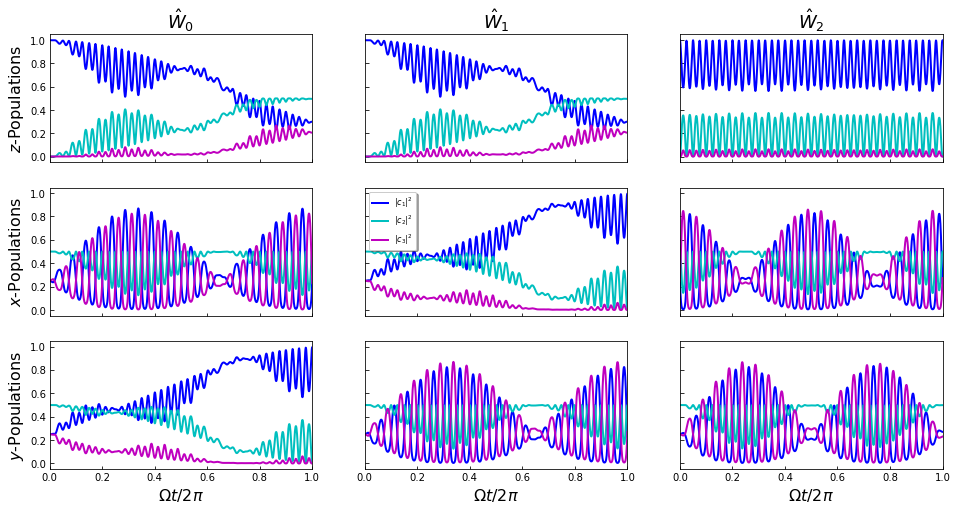

In [87]:
#----- Compute Spin Populations -----
l1 = loop(psi0, t, Thetas[0], Phis[0], args, proj_ops=proj_ops) #Loop 1
l2 = loop(psi0, t, Thetas[1], Phis[1], args, proj_ops=proj_ops) #Loop 2
l3 = loop(psi0, t, Thetas[2], Phis[2], args, proj_ops=proj_ops) #Loop 3

#----- Plot Results -----
def draw_pops(ax_arr, l, labels):
    ''' Plots z, x, y populations on 3 axes given in ax_arr '''
    
    lines = ['b-', 'c-', 'm-'] #Linestyles for 3 populations
    
    j = 0
    for ax in ax_arr:
        for i in range(0,3):
            ax.plot( l.times*(slow_f/2/np.pi), l.expect[i+j], lines[i], lw=2, label=labels[i])
        j += 3

#--- Make Figure ---
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(16,8) )
fs = 16 #Label fontsize
labels = ['$|c_{1}|^2$', '$|c_{2}|^2$', '$|c_{3}|^2$'] #Plot labels

for i, l in enumerate([l1, l2, l3]):
    draw_pops( ax[:,i], l, labels )

#--- Plot Settings ---
for i, a in enumerate(ax[0,:]):
    a.set_title( '$\hat{W}_{%d}$' %i, fontsize=fs+2)

for a in ax[2,0], ax[2,1], ax[2,2]:
    a.set_xlabel('$\Omega t/2\pi$', fontsize=fs) #Comman x-label
ax[0,0].set_ylabel('$z$-Populations', fontsize=fs)
ax[1,0].set_ylabel('$x$-Populations', fontsize=fs)
ax[2,0].set_ylabel('$y$-Populations', fontsize=fs)

ax[1,1].legend(loc='best', fancybox=True, shadow=True, framealpha=1, fontsize=8)
for ax in ax.reshape(-1):
    ax.set_xlim([0,1]) #Remove extra spaces at ends
    ax.tick_params(direction='in') #Set grid-ticks inward
plt.show()

## Evolution Operators

In [48]:
from scipy.special import j0

def u_theory(Theta, Phi, phi_const=True):
    '''  '''
    
    g = (1/2) * ( j0(2*Omega0/floq_f) -1 ) #Phase factor

    if phi_const is True:
        'Use phi=const. form'
        U = ( -1j*g * 4*np.pi*(-1*np.cos(Phi[1])*sx + np.sin(Phi[1])*sy) ).expm()
    elif phi_const is False:
        'Use phi linear in t form, assuming no constant part & phi is harmonic of slow_f'
        n = Phi[0]/slow_f
        U = ( -1j*g * (4*np.pi*n * np.sin(Theta[1])**2)*sz ).expm()
    
    return U

In [59]:
#----- Compute States -----
l1_s = loop(psi0, t, Thetas[0], Phis[0], args) #Loop 1
l2_s = loop(psi0, t, Thetas[1], Phis[1], args) #Loop 2
l3_s = loop(psi0, t, Thetas[2], Phis[2], args) #Loop 3

psif_1, psif_2, psif_3 = l1_s.states[-1], l2_s.states[-1], l3_s.states[-1] #Final states

#--- Theoretical Evo. Ops -----
W1, W2, W3 = u_theory(Thetas[0], Phis[0]), u_theory(Thetas[1], Phis[1]), u_theory(Thetas[2], Phis[2], phi_const=False)

fl1, fl2, fl3 = W1*psi0, W2*psi0, W3*psi0 #Theory final states

#--- Compare Results ---
print('')
print( '----- Final State Overlap -----' )
print( '<psi_n|psi_t>, n=simulation, t=theory' )
for i, pair in enumerate([ [psif_1, fl1], [psif_2, fl2], [psif_3, fl3] ]):
    inner = pair[0].overlap(pair[1]) #Inner product
    print( f'Loop {i+1}: {np.real(inner):.4f} + {np.imag(inner):.4f}i' )

print('')
print( '----- Wilson Loops -----' )
print( 'Tr( W3[W2,W1] )' )
W = (W3*(W2*W1 - W1*W2)).tr() #Wilson loop
g = (1/1) * ( j0(2*Omega0/floq_f) -1 ) #Phase factor
Wdiff = -2 * (np.sin(2*np.pi*g)**3) #Predicted diff.
print( f'Difference: {np.real(W):.4f} + {np.imag(W):.4f}i' )
print( f'Theory: {Wdiff:.4f}' )


----- Final State Overlap -----
<psi_n|psi_t>, n=simulation, t=theory
Loop 1: 0.9986 + -0.0446i
Loop 2: 0.9986 + -0.0446i
Loop 3: 0.9991 + -0.0017i

----- Wilson Loops -----
Tr( W3[W2,W1] )
Difference: 1.9728 + -0.0000i
Theory: 1.9728


In [77]:
sigx, fx = qt.sigmax(), qt.operators.jmat(1, 'x')

phase = np.pi/2
pauli = (-1j*phase*sigx).expm()
hyp = (-1j*phase*fx).expm()

print( pauli )
print( hyp )

print('')
peig, feig = pauli.eigenstates(), hyp.eigenstates()
pstates, fstates = peig[1], feig[1]
for s in pstates:
    print( s.unit() )
print('')
for s in fstates:
    print( s.unit() )

print('')
sig0, f0 = qt.basis(2,0), qt.basis(3,0)
print( pauli*sig0 )
print( hyp*f0 )

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j          0. -0.70710678j -0.5+0.j        ]
 [ 0. -0.70710678j  0. +0.j          0. -0.70710678j]
 [-0.5+0.j          0. -0.70710678j  0.5+0.j        ]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.70710678]
 [-0.70710678]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.5       ]
 [0.70710678]
 [0.5       ]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[-0.5       ]
 [ 0.70710678]
 [-0.5       ]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.70710678]
 [ 0.        ]
 [-0.70710678]]

Quantum object: dims = [[2], [1]], shape = (2, 1), t